# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [3]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.1)


In [4]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import time
import sklearn

import warnings
warnings.filterwarnings("ignore")

### Знакомство с данными

In [5]:
# Посмотрим на данные
data = pd.read_csv('/datasets/autos.csv')
display(data)
data.info()
data.describe()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


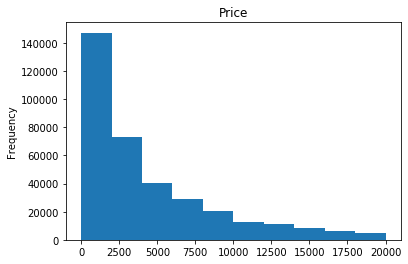

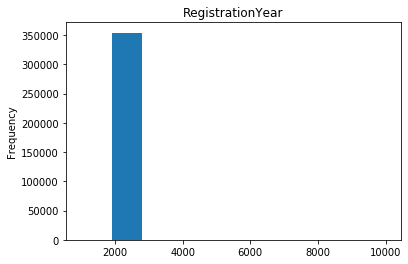

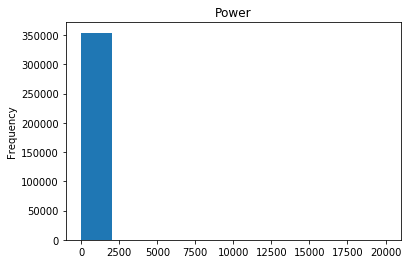

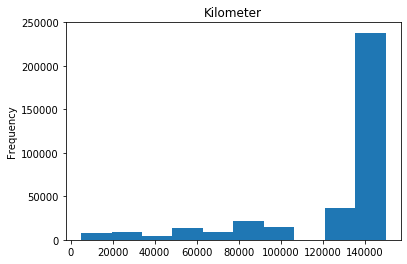

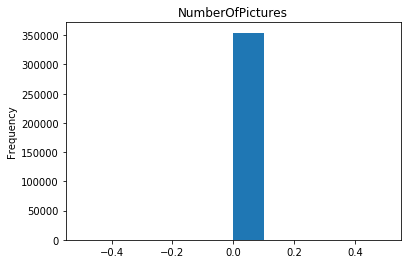

In [6]:
# Посмотрим на распределение численных признаков
numeric_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures']
for col in numeric_cols:
    data[col].plot.hist()
    plt.title(col)
    plt.show()

In [7]:
# Посмотрим на пропуски и дубли
print(f'Количество пропусков по столбцам: {data.isnull().mean()*100}')
print(f'Количество дублей: {data.duplicated().sum()}')

Количество пропусков по столбцам: DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64
Количество дублей: 4


In [8]:
# Удалим дубли
data.drop_duplicates(inplace=True)

**Выводы:**

Столец *DateCrawled* не несет полезной информации для прогнозирования цены. Уберем его из признаков.

Столец *VehicleType* имеет пропуски, которые необходимо обработать. Оставим в качестве признака.

Столец *RegistrationYear* имеет выбросы, видимо пользователи или не знали дату, или хотели скрыть такую информацию. Оставим в качестве признака. Возможно стоит создать новый столбец, который является разностью года скачивания анкеты из базы и годом регистрации автомобиля.

Столец *Gearbox* имеет пропуски, содержит категориальные признаки. Оставим в качестве признака.

Столец *Power* имеет выбросы. Оставим в качестве признака.

Столбец *Model* имеет пропуски, содержит категориальные признаки. Так как при кодировании получится слишком много признаков, то уберем столбец из признаков.

Столбец *Kilometer* имеет не нормальное распределение данных, с явном перекосом в сторону больших значений. Оставим в качестве признака.

Столбец *RegistrationMonth* не несет полезной информации для прогнозирования цены. Уберем его из признаков.

Столбец *FuelType* имеет пропуски, содержит категориальные признаки. Оставим в качестве признака.

Столбец *Brand* содержит категориальные признаки. Оставим в качестве признака.

Столбец *NotRepaired* имеет пропуски, содержит категориальные признаки. Скорее всего пропуски вызваны, тем что пользователи хотели скрыть факт ремонта. Основываяь на этой идее, можно заполнить пропуски 1 или посмотреть на зависимость с годом регистрации. Оставим в качестве признака.

Столбец *DateCreated* не несет полезной информации для прогнозирования цены. Уберем его из признаков.

Столбец *NumberOfPictures* содержит только нули.Уберем его из признаков.

Столбец *PostalCode* содержит информацио о местоположении. Так как при кодировании получится слишком много признаков, то уберем столбец из признаков.

Столбец *LastSeen* не несет полезной информации для прогнозирования цены. Уберем его из признаков.

Численные значения имеют разный масштаб, для улучшения качества модели их стоит отмасштабировать 

<div class="alert alert-block alert-info">
<b>Совет </b>  Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: `pandas_profiling.ProfileReport(df)`
    

In [9]:
# Выделим отдельно целевой признак и признаки для обучения. Затем разделим их на тренировочную и валидационные выборки
dropped_cols = [
    'DateCrawled', 'Price', 'RegistrationMonth', 
    'DateCreated', 'NumberOfPictures', 'PostalCode', 
    'LastSeen','Model']
features = data.drop(columns=dropped_cols)
target = data['Price']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

### Заполнение пропусков

In [10]:
# Посмотрим на пропуски в тестовой и валидационной выборках
print('Количество пропусков в тренировочной выборке:')
print(features_train.isnull().mean()*100)
print('='*50)
print('Количество пропусков в валидационой выборке:')
print(features_valid.isnull().mean()*100)

Количество пропусков в тренировочной выборке:
VehicleType         10.530039
RegistrationYear     0.000000
Gearbox              5.605159
Power                0.000000
Kilometer            0.000000
FuelType             9.257148
Brand                0.000000
NotRepaired         20.041539
dtype: float64
Количество пропусков в валидационой выборке:
VehicleType         10.727831
RegistrationYear     0.000000
Gearbox              5.571609
Power                0.000000
Kilometer            0.000000
FuelType             9.359762
Brand                0.000000
NotRepaired         20.192568
dtype: float64


In [12]:
# Пропуски в столбце VehicleType заполним модой
features_train['VehicleType'].fillna(features_train['VehicleType'].mode()[0], inplace=True)
features_valid['VehicleType'].fillna(features_train['VehicleType'].mode()[0], inplace=True)

In [13]:
# Пропуски в столбце Gearbox заполним модой
features_train['Gearbox'].fillna(features_train['Gearbox'].mode()[0], inplace=True)
features_valid['Gearbox'].fillna(features_train['Gearbox'].mode()[0], inplace=True)

In [14]:
# Пропуски в столбце FuelType заполним модой
features_train['FuelType'].fillna(features_train['FuelType'].mode()[0], inplace=True)
features_valid['FuelType'].fillna(features_train['FuelType'].mode()[0], inplace=True)

In [15]:
# Пропуски в столбце NotRepaired заполним модой
features_train['NotRepaired'].fillna(features_train['NotRepaired'].mode()[0], inplace=True)
features_valid['NotRepaired'].fillna(features_train['NotRepaired'].mode()[0], inplace=True)

In [16]:
# Проверка
# Посмотрим на пропуски в тестовой и валидационной выборках
print('Количество пропусков в тренировочной выборке:')
print(features_train.isnull().mean()*100)
print('='*50)
print('Количество пропусков в валидационой выборке:')
print(features_valid.isnull().mean()*100)

Количество пропусков в тренировочной выборке:
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64
Количество пропусков в валидационой выборке:
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64


### Закодируем категориальные признаки

In [17]:
# Закодируем категориальные признаки
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
# Проверим, что признаки в обоих выборках равны
set(features_train.columns) == set(features_valid.columns)

True

### Отмасштабируем численные признаки

In [18]:
scaler = StandardScaler()
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 

## Обучение моделей

Подберем оптимальные признаки для моделей дерева решений, случайного леса и градиентного бустинга 

In [19]:
# Подберем параметры для дерева решений
DTR = DecisionTreeRegressor(random_state=12345)
params = {'max_depth':list(range(1,32,5))}
DTR = GridSearchCV(DTR, params, scoring='neg_root_mean_squared_error', cv=3)
DTR.fit(features_train, target_train)
DTR.best_params_

{'max_depth': 16}

In [20]:
# Подберем параметры для случайного леса
RFR = RandomForestRegressor(random_state=12345)
params = {'max_depth':list(range(1,32,10)), 
         'n_estimators': list(range(1,80,20))}
RFR = GridSearchCV(RFR, params, scoring='neg_root_mean_squared_error', cv=3, verbose=144, n_jobs=-1)
RFR.fit(features_train, target_train)
RFR.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START max_depth=1, n_estimators=1................................
[CV 1/3; 1/16] END max_depth=1, n_estimators=1;, score=-3799.259 total time=   0.3s
[CV 2/3; 1/16] START max_depth=1, n_estimators=1................................
[CV 2/3; 1/16] END max_depth=1, n_estimators=1;, score=-3770.587 total time=   0.3s
[CV 3/3; 1/16] START max_depth=1, n_estimators=1................................
[CV 3/3; 1/16] END max_depth=1, n_estimators=1;, score=-3804.325 total time=   0.3s
[CV 1/3; 2/16] START max_depth=1, n_estimators=21...............................
[CV 1/3; 2/16] END max_depth=1, n_estimators=21;, score=-3799.235 total time=   2.0s
[CV 2/3; 2/16] START max_depth=1, n_estimators=21...............................
[CV 2/3; 2/16] END max_depth=1, n_estimators=21;, score=-3770.424 total time=   1.9s
[CV 3/3; 2/16] START max_depth=1, n_estimators=21...............................
[CV 3/3; 2/16] END max_depth=1,

{'max_depth': 21, 'n_estimators': 61}

In [21]:
# Подберем параметры для случайного леса
LGBM = LGBMRegressor(random_state=12345)
params = {'max_depth':list(range(1,32,10)), 
         'n_estimators': list(range(1,80,20))}
LGBM = GridSearchCV(LGBM, params, scoring='neg_root_mean_squared_error', cv=3, verbose=48)
LGBM.fit(features_train, target_train)
LGBM.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START max_depth=1, n_estimators=1................................
[CV 1/3; 1/16] END max_depth=1, n_estimators=1;, score=-4393.346 total time=   1.2s
[CV 2/3; 1/16] START max_depth=1, n_estimators=1................................
[CV 2/3; 1/16] END max_depth=1, n_estimators=1;, score=-4366.154 total time=   1.4s
[CV 3/3; 1/16] START max_depth=1, n_estimators=1................................
[CV 3/3; 1/16] END max_depth=1, n_estimators=1;, score=-4403.627 total time=   1.2s
[CV 1/3; 2/16] START max_depth=1, n_estimators=21...............................
[CV 1/3; 2/16] END max_depth=1, n_estimators=21;, score=-3361.730 total time=   5.7s
[CV 2/3; 2/16] START max_depth=1, n_estimators=21...............................
[CV 2/3; 2/16] END max_depth=1, n_estimators=21;, score=-3333.511 total time=   5.7s
[CV 3/3; 2/16] START max_depth=1, n_estimators=21...............................
[CV 3/3; 2/16] END max_depth=1,

{'max_depth': 21, 'n_estimators': 61}

## Анализ моделей

In [22]:
# Создадим различные модели с оптимальными параметрами, полученными в предыдущем пункте
LR = LinearRegression()
DTR = DecisionTreeRegressor(random_state=12345, max_depth=16)
RFR = RandomForestRegressor(random_state=12345, max_depth=21, n_estimators=61)
LGBM = LGBMRegressor(random_state=12345, max_depth=21, n_estimators=61)
# Создадим списки, содержащие время работы и значения метрики
train_time = []
pred_time = []
train_rmse = []
valid_rmse = []
models = [LR, DTR, RFR, LGBM]
# Обучим модели и оценим качество предсказаний
for model in models:
    start_time = time.time()
    model.fit(features_train, target_train)
    train_time.append(time.time() - start_time)
    start_time = time.time()
    pred_valid = model.predict(features_valid)
    pred_time.append(time.time() - start_time)
    pred_train = model.predict(features_train)
    train_rmse.append(mean_squared_error(target_train, pred_train, squared=False))
    valid_rmse.append(mean_squared_error(target_valid, pred_valid, squared=False))

In [23]:
# Создадим датафрейм с результатами
d = {'Время на обучение':train_time,
    'Время на предсказание':pred_time,
    'RMSE на тренировочной выборке, EUR':train_rmse,
    'RMSE на валидационной выборке, EUR':valid_rmse,
    }
df = pd.DataFrame(d, index=['Линейная регрессия', "Дерево решений", "Случайный лес", "Градиентный бустинг"])
df.head()

,Время на обучение,Время на предсказание,"RMSE на тренировочной выборке, EUR","RMSE на валидационной выборке, EUR"
Линейная регрессия,3.873527,0.193223,3422.370060,3417.270631
Дерево решений,2.529662,0.038297,1600.968917,2013.634860
Случайный лес,147.043198,2.206714,1297.824740,1797.434354
Градиентный бустинг,177.753121,0.533343,1925.535092,1938.759177


## Выводы

В рамках данного проекта были подготовлены данные и обучены 4 модели для предсказания цен автомобилей. Были получены следующие результаты:

- Наибольшей скоростью обучения и предсказания обладает дерево решений, 2,5с и 0,04с соответсвенно. Больше всего времени на обучение требуется градиентному бустингу 178с, затем идет случайный лес с 147с. При этом градиентный бустинг предсказывает в разы быстрее, чем случайный лес, 0,5с протиив 2,2с.
- Согласно сравнению значений метрики RMSE для тренировочной и валидационной выборок, дерево решений и случайный лес переобучились. Возможно, стоило уменьшить допустимый диапазон на глубину и количество деревьев.
- С учетом переобучения наиболее качественной моделью является градиентный бустинг, так как на тренировочной и валидационной выборках модель выдает схожие и относительной хорошие значения.

Таким образом, при заданном диапазоне оптимизации параметров в плане качества и скорости предсказаний модель градиентного бустинга является лучшей. Однако, она обучается намного дольше других моделей.  